# 11.2. Multiple Categories

- consider panelists in multiple racial and ethnic categories ==> new statistic to simulate

## 11.2.1. Jury Selection in Alameda County

- In 2010, the American Civil Liberties Union (ACLU) of Northern California presented a report on jury selection in Alameda County, California: **Underrepresentation** of certain racial and ethnic groups among jury panelists. 
- “All persons selected for jury service shall be selected **at random**, from a source or sources inclusive of a representative cross section of the population of the area served by the court.”

## 11.2.2. Composition of Panels in Alameda County

- racial and ethnic composition of jury panels in Alameda County.
- data on the composition of the jury panels in 11 felony trials in Alameda County in the years 2009 and 2010: 1453 jurors

In [3]:
from datascience import *

jury = Table().with_columns(
    'Ethnicity', make_array('Asian/PI', 'Black/AA', 'Caucasian', 'Hispanic', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.54, 0.12, 0.01),
    'Panels', make_array(0.26, 0.08, 0.54, 0.08, 0.04)
)

jury

##### overrepresented and underrepresented

Ethnicity,Eligible,Panels
Asian/PI,0.15,0.26
Black/AA,0.18,0.08
Caucasian,0.54,0.54
Hispanic,0.12,0.08
Other,0.01,0.04


Some ethnicities are overrepresented and some are underrepresented on the jury panels in the study. In particular, panelists in the Black/AA and Hispanic categories are underrepresented.

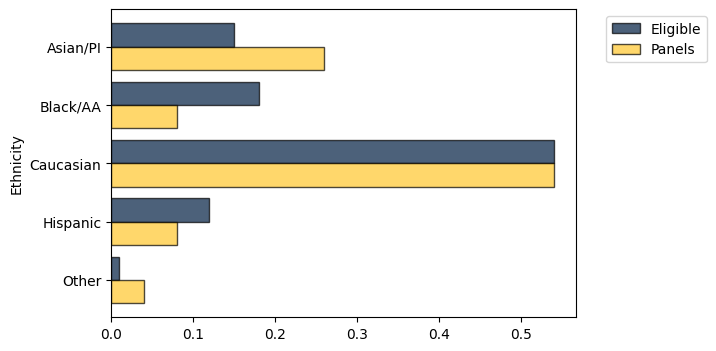

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

jury.barh('Ethnicity')

## 11.2.3. Comparison with Panels Selected at Random

In [5]:
### there's a difference here... but there's always a difference

eligible_population = jury.column('Eligible')
# eligible_population     ### an array 
sample_distribution = sample_proportions(1450, eligible_population)   ### https://www.data8.org/datascience/reference-nb/datascience-reference.html
# sample_distribution
panels_and_sample = jury.with_column('Random Sample', sample_distribution)
panels_and_sample

##### random sample distribution =~ eligible population

Ethnicity,Eligible,Panels,Random Sample
Asian/PI,0.15,0.26,0.144138
Black/AA,0.18,0.08,0.173793
Caucasian,0.54,0.54,0.558621
Hispanic,0.12,0.08,0.115862
Other,0.01,0.04,0.00758621


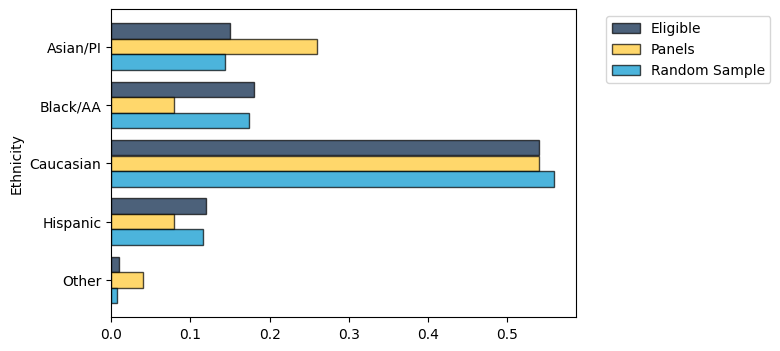

In [6]:
panels_and_sample.barh('Ethnicity')

##### !!! important !!!
##### the random sample distribution fits the eligible distribution
##### look at the two blues

##### this is good but we need a statistic because we can't look at 
##### the charts only to come up with conclusions

The bar chart shows that the distribution of the **random sample resembles the eligible population** but the distribution of the panels does not.

To assess whether this observation is particular to one random sample or more general, we can simulate multiple panels under the model of random selection and see what the simulations predict. But we won’t be able to look at thousands of bar charts like the one above. We need a statistic that will help us assess whether or not the model or random selection is supported by the data.

## 11.2.4. A New Statistic: The Distance between Two Distributions

- **total variation distance**

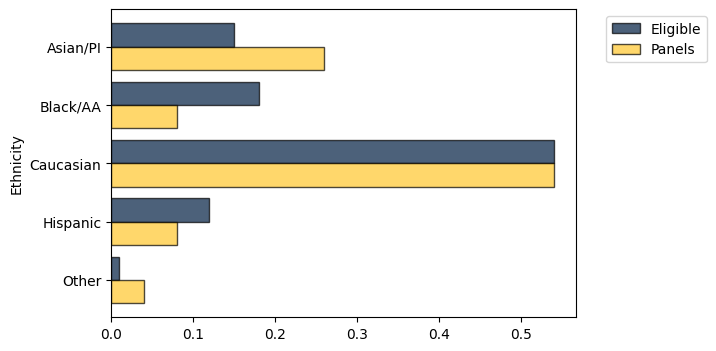

In [7]:
jury.barh('Ethnicity')

### Question: How to quantify the distance between two distributions?

In [8]:
### add a column (array) of differences between proportions
### abs( ): different two numbers are: if the numbers are x and y, 
### the distance between them is | x - y |

jury_with_diffs = jury.with_column(
    'Difference', jury.column('Panels') - jury.column('Eligible')
)

jury_with_diffs

### the sum of Difference entries is 0
### The  proportions in each of the two columns Panels and Eligible add up to 1, 
### and so the give-and-take between their entries must add up to 0

Ethnicity,Eligible,Panels,Difference
Asian/PI,0.15,0.26,0.11
Black/AA,0.18,0.08,-0.1
Caucasian,0.54,0.54,0
Hispanic,0.12,0.08,-0.04
Other,0.01,0.04,0.03


In [9]:
### To avoid the cancellation, we drop the negative signs and then add all the entries. 

import numpy as np
jury_with_diffs = jury_with_diffs.with_column(
    'Absolute Difference', np.abs(jury_with_diffs.column('Difference')
                                 )
)
jury_with_diffs

Ethnicity,Eligible,Panels,Difference,Absolute Difference
Asian/PI,0.15,0.26,0.11,0.11
Black/AA,0.18,0.08,-0.1,0.1
Caucasian,0.54,0.54,0,0
Hispanic,0.12,0.08,-0.04,0.04
Other,0.01,0.04,0.03,0.03


In [10]:
##### TVD is the new statistic: the variation of the distribution
##### total variation distance (TVD) between the distribution of 
##### ethnicities in the eligible juror population and the distribution in the panels. 

jury_with_diffs.column('Absolute Difference').sum() / 2
# float(jury_with_diffs.column('Absolute Difference').sum() / 2)##### total variation distance (TVD) #####

# jury_with_diffs.column('Absolute Difference').sum() / 2
# np.round(jury_with_diffs.column('Absolute Difference').sum() / 2, 5)  ### np round
# round((jury_with_diffs.column('Absolute Difference').sum() / 2),3 )     ### python round

### https://stackoverflow.com/questions/51349738/np-round-or-np-around-doesnt-work
# float("{:0.2f}".format(jury_with_diffs.column('Absolute Difference').sum() / 2))
### https://www.reddit.com/r/learnpython/comments/1dxmqm5/round_fuction_not_working_properly/
# print(f{(jury_with_diffs.column('Absolute Difference').sum() / 2): 0.2f})

# type(jury_with_diffs.column('Absolute Difference').sum() / 2)

# float(jury_with_diffs.column('Absolute Difference').sum() / 2)


0.14000000000000001

This quantity 0.14 is the total variation distance (TVD) between the distribution of ethnicities in the eligible juror population and the distribution in the panels.

In general, the total variation distance between two distributions measures how close the distributions are. The larger the TVD, the more different the two distributions appear.



## 11.2.5. Simulating the Statistic Under the Model
To see how the TVD varies across random samples, we will simulate it repeatedly under the model of random selection from the eligible population.

Let’s organize our calculation. Since we are going to be computing total variation distance repeatedly, we will first write a function that computes it for two given distributions.

The function total_variation_distance takes two arrays containing the distributions to compare, and returns the TVD between them.

-  the model of random selection from the eligible population


In [11]:
##### two distributions (arrays): sum of ((one minus the other) divided by 2)

def total_variation_distance(distribution_1, distribution_2):
    return sum(np.abs(distribution_1 - distribution_2)) / 2    ### abs()

In [12]:
### test the tvd function: Panels vs. Eligible

# total_variation_distance(jury.column('Panels'), jury.column('Eligible'))
float(total_variation_distance(jury.column('Panels'), jury.column('Eligible')))

0.14

In [13]:
### the function works; now do it 1000 times
##### use sample_proportions to generate a random sample from the eligible population.

sample_distribution = sample_proportions(1453, eligible_population)
# sample_distribution

### sample_proportions(sample_size, model_proportions) 
#####
##### TVD between random sample distribution and the eligible population
total_variation_distance(sample_distribution, eligible_population)
### do it multiple times to see the variation

0.0072401927047488126

The distances are quite a bit smaller than 0.14.

### 11.2.5.1. Simulating One Value of the Statistic

In [14]:
# Simulate one simulated value of 
# the total variation distance between
# the distribution of a sample selected at random
# and the distribution of the eligible population

def one_simulated_tvd():
    sample_distribution = sample_proportions(1453, eligible_population)
    return total_variation_distance(sample_distribution, eligible_population)

In [15]:
one_simulated_tvd()

0.030633172746042665

### 11.2.5.2. Simulating Multiple Values of the Statistic
Loop to create an array of 5000 distances

In [16]:
tvds = make_array()
repetitions = 5000
for i in np.arange(repetitions):
    # tvds = np.append(tvds, one_simulated_tvd)
    tvds = np.append(tvds, one_simulated_tvd())

# len(tvds)  ### 5000
tvds

array([ 0.01489332,  0.02379215,  0.01648314, ...,  0.0205437 ,
        0.02043359,  0.02029594])

## 11.2.6. Assessing the Model of Random Selection
- Draw the empirical histogram of the simulated distances
- Draw the model statistic (0.14). 

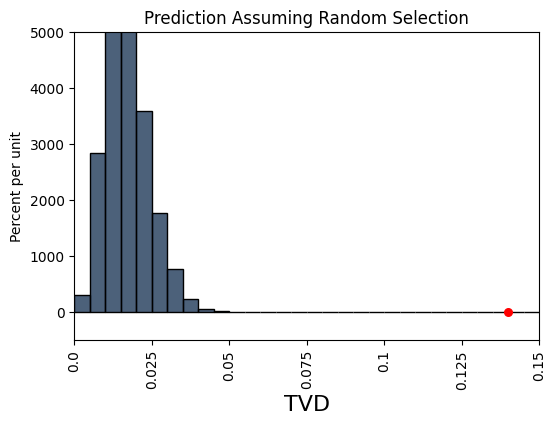

In [17]:
import matplotlib.pyplot as plots

Table().with_column('TVD', tvds).hist(bins = np.arange(0, 0.2, 0.005))

# Plotting parameters; you can ignore this code
plots.title('Prediction Assuming Random Selection')
plots.xlim(0, 0.15)
plots.ylim(-5, 50)
plots.scatter(0.14, 0, color='red', s=30);

The simulation shows that the composition of the panels in the ACLU study is not consistent with the model of random selection. Our analysis supports the ACLU’s conclusion that the panels were not representative of the distribution provided for the eligible jurors.

## 11.2.7. Reasons for the Bias

## 11.2.8. Data Quality

- Eligible Jurors
- Panels

## 11.2.9. Conclusion

- We can conclude that the distribution provided for the panelists who reported for service does not look like a random sample from the estimated distribution in the eligible population.- The simulation shows that the composition of the panels in the ACLU study is not consistent with the model of random selection.
- The analysis supports the ACLU’s conclusion that the panels were not representative of the distribution provided for the eligible jurors.

